In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download and unzip our files

In [2]:
# from zipfile import *
# is_zipfile('/content/drive/MyDrive/Colab Notebooks/PyTorch/5/cv/archive.zip')


In [3]:
# import zipfile

# with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/PyTorch/5/cv/archive.zip', mode='a') as zf:
#     for file in zf.namelist():
#         print(file)

In [4]:
# import zipfile, glob

# extract_dir = '/content/drive/MyDrive/Colab Notebooks/PyTorch/5/cv'

# with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/PyTorch/5/cv/archive.zip') as zf:
#     zf.extractall(extract_dir)


In [88]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import pandas as pd
import seaborn

In [89]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Creat objects for transformations

## Prepare our datas

In [90]:
train_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                         
                         # Настройки для расширения датасета
                         tt.transforms.Resize((48, 48)),
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      # Приведение к тензору

test_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [91]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/PyTorch/5/cv/'
print(os.listdir(data_dir))

['pytorch_cource_work.ipynb', 'archive.zip', 'Untitled0.ipynb', 'leapGestRecog', 'leapgestrecog', 'emotion_detection_model_state_50_epochs.pth']


In [92]:
list_dir = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']

In [93]:
classes_train = []
for i in list_dir:
  classes_train = os.listdir(data_dir + 'leapGestRecog/'+i)

In [94]:
classes_train = pd.unique(classes_train)
print(classes_train)

['01_palm' '02_l' '03_fist' '04_fist_moved' '05_thumb' '06_index' '07_ok'
 '08_palm_moved' '09_c' '10_down']


In [95]:
for i in list_dir:
  train_dataset = ImageFolder(data_dir + 'leapgestrecog/leapGestRecog/'+i, train_transforms)




In [96]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(train_dataset, test_size = 0.3, shuffle = True)


In [152]:
batch_size = 10

## Creat DataLoader

In [153]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [154]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
    

See our images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([1, 48, 48])


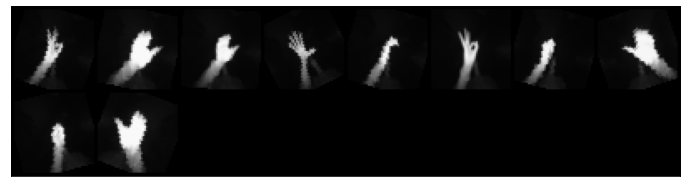

In [155]:
show_batch(train_dataloader)

In [156]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [157]:
device = get_default_device()
device

device(type='cuda')

In [158]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

## Create model

In [159]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(self.conv_block(256, 256), self.conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(256, 512)
        self.conv6 = self.conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes),
                                        nn.Softmax(dim=1))
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [160]:
model = to_device(ResNet(1, len(classes_train)), device)

## training

In [164]:
# Если работаете на гпу, очищаем весь кэш
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()


epochs = 150
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr)

In [165]:
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

150 epochs, 140 total_steps per epoch


In [166]:
print(torch.__version__)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

1.8.0+cu101


In [167]:
epoch_losses = []
true_y = []
pred_y = []

sm=nn.Softmax(dim=0)

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data, labels = data[:10], labels[:10]    
        
        optimizer.zero_grad()
        
        outputs = model(data)
        
#         print(outputs[0])
#         print(labels[0])
        _, preds = torch.max(outputs, 1)
        #print(preds)
        
        true_y.append(labels.to('cpu'))
        pred_y.append(outputs.to('cpu'))
        
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1, loss:  2.3153413346835543
Epoch 2, loss:  2.2384356473173415
Epoch 3, loss:  2.1812244824000766
Epoch 4, loss:  2.147359131063734
Epoch 5, loss:  2.1267272540501185
Epoch 6, loss:  2.110114929505757
Epoch 7, loss:  2.0888891552175792
Epoch 8, loss:  2.0819921135902404
Epoch 9, loss:  2.0684944638184137
Epoch 10, loss:  2.051474978242602
Epoch 11, loss:  2.0000544377735685
Epoch 12, loss:  1.9825053002153123
Epoch 13, loss:  1.9606471802507128
Epoch 14, loss:  1.9491939553192683
Epoch 15, loss:  1.9599034351961953
Epoch 16, loss:  1.9547962827341898
Epoch 17, loss:  1.9493707716464996
Epoch 18, loss:  1.9510310138974871
Epoch 19, loss:  1.94950692653656
Epoch 20, loss:  1.910850135769163
Epoch 21, loss:  1.886952577318464
Epoch 22, loss:  1.8691971038069044
Epoch 23, loss:  1.8597331276961735
Epoch 24, loss:  1.8558719422136034
Epoch 25, loss:  1.854138159751892
Epoch 26, loss:  1.8601937660149166
Epoch 27, loss:  1.804189258813858
Epoch 28, loss:  1.770570639201573
Epoch 29, l

## Lets see our losses

####The following result reflects batch_size = 20 and epoch = 100 

1.6394703762871878


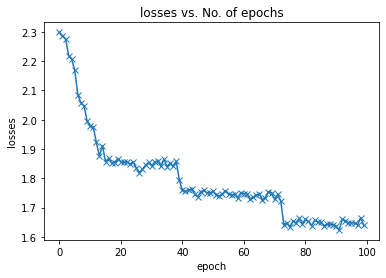

In [151]:
# losses = [np.mean(loss) for loss in epoch_losses]
# plt.plot(losses, '-x')
# plt.xlabel('epoch')
# plt.ylabel('losses')
# plt.title('losses vs. No. of epochs')
# print(losses[-1])

#### The following result reflects batch_size = 5 and epoch = 150 (the best loss = 1.461)

Text(0.5, 1.0, 'losses vs. No. of epochs')

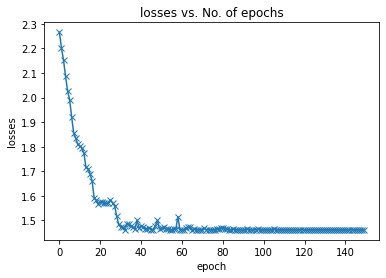

In [125]:
# losses = [np.mean(loss) for loss in epoch_losses]
# plt.plot(losses, '-x')
# plt.xlabel('epoch')
# plt.ylabel('losses')
# plt.title('losses vs. No. of epochs')

#### And final result reflects batch_size = 15 and epoch = 150 

1.4611519055707114


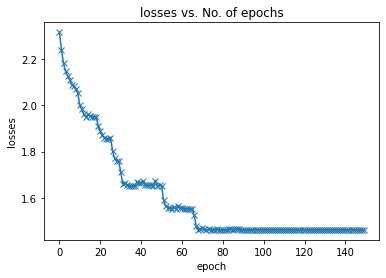

In [168]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')
print(losses[-1])

## Save our model

In [169]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/PyTorch/5/cv/emotion_detection_model_state_50_epochs.pth')

In [170]:
net=ResNet(1, len(classes_train)).to(device)
net.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/PyTorch/5/cv/emotion_detection_model_state_50_epochs.pth'))
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

## cv2.imshow does not work in colaboratory but we can use cv2_imshow. Download it.

In [171]:
from google.colab.patches import cv2_imshow

In [180]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN
from google.colab.patches import cv2_imshow


 

# Класс детектирования и обработки лица с веб-камеры 
class FaceDetector(object):

    def __init__(self, mtcnn, resnet):
        # Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
        self.cap = cv2.VideoCapture('/content/drive/MyDrive/Colab Notebooks/PyTorch/5/videoplayback.mp4') # My camera doen't work. Lets send movie file.
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = resnet

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, probs, landmarks, emotion):
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # пишем на кадре какая эмоция распознана
                cv2.putText(frame, 
                    emotion, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Рисуем особенные точки
                cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            print('Something wrong im draw function!')

        return frame
    
    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]-40):int(box[3]+40), 
                int(box[0]-40):int(box[2]+40)])
        return faces
    
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            print('Hello, nice to meet you')
            return '01_palm'
        elif digit == 1:
            print('Слушаю Вас')
            return '02_l'
        elif digit == 2:
            print('Не буду спорить')
            return '03_fist'
        elif digit == 3:
            print('Всем привет')
            return 'Hello - 04_fist_moved'
        elif digit == 4:
            print('ну и что это опять')

            return '05_thumb'
        elif digit == 5:
            print('Не пойму, что хотите показать этим пальцем')
            return '06_index'
        elif digit == 6:
            return '07_ok'
        elif digit == 7:
            print('We are fine')
            return '08_palm_moved'
        elif digit == 8:
            print('Служа совьецкому союзу')
            return '09_c'
        elif digit == 9:
            print('Пока')
            return '10_down'

       
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):   
        x = 0           
        # Заходим в бесконечный цикл
        while x<5:   # We delete unlimited cycle because cv2_imshow shows results by frame with process's crashes.
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = self.cap.read()
            try:
                # детектируем расположение лица на кадре, вероятности на сколько это лицо
                # и особенные точки лица
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
                
                # Вырезаем лицо из кадра
                face = self.crop_faces(frame, boxes)[0]
                # Меняем размер изображения лица для входа в нейронную сеть
                face = cv2.resize(face,(48,48))
                # Превращаем в 1-канальное серое изображение
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
                torch_face = torch.from_numpy(face).unsqueeze(0).to(self.device).float()
                # Загужаем наш тензор лица в нейронную сеть и получаем предсказание
                emotion = self.emodel(torch_face[None, ...])
                # Интерпретируем предсказание как строку нашей эмоции
                emotion = self.digit_to_classname(emotion[0].argmax().item())

                # Рисуем на кадре
                self._draw(frame, boxes, probs, landmarks, emotion)
                
                cv2_imshow("Gray face")    # we have to change it

            except Exception as e:
                print('Something wrong im main cycle!')
                print(f'error : {e}')

            # Показываем кадр в окне, и назвываем его(окно) - 'Face Detection'
            cv2_imshow(frame) # we have to change it
            
            
            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            x += 1
                
        # Очищаем все объекты opencv, что мы создали
        self.cap.release()
        cv2.destroyAllWindows()

Hello, nice to meet you
Something wrong im main cycle!
error : 'str' object has no attribute 'clip'


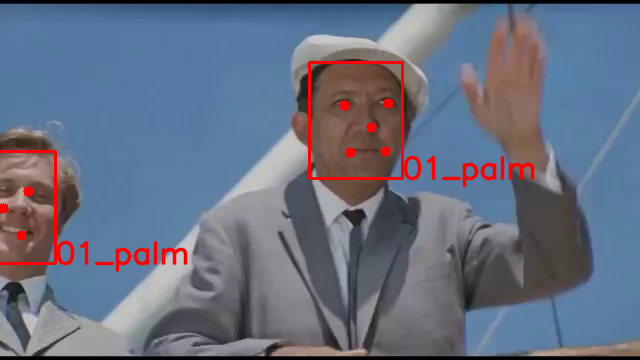

Something wrong im main cycle!
error : OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



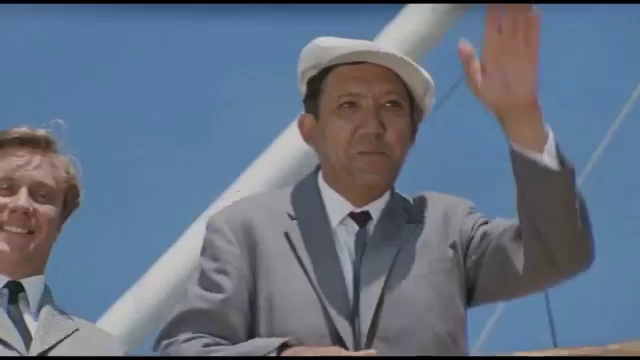

Something wrong im main cycle!
error : OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



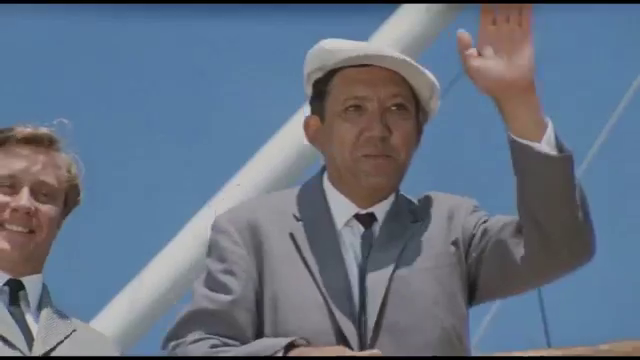

Something wrong im main cycle!
error : OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



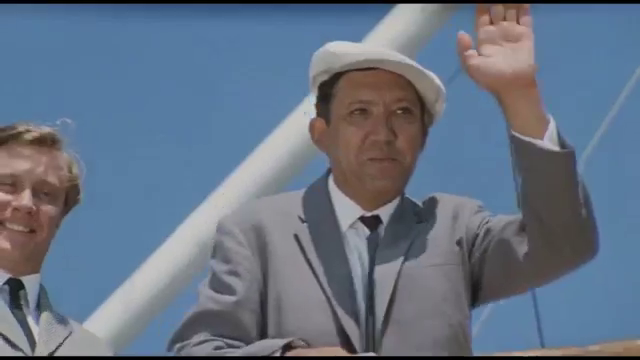

Something wrong im main cycle!
error : OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



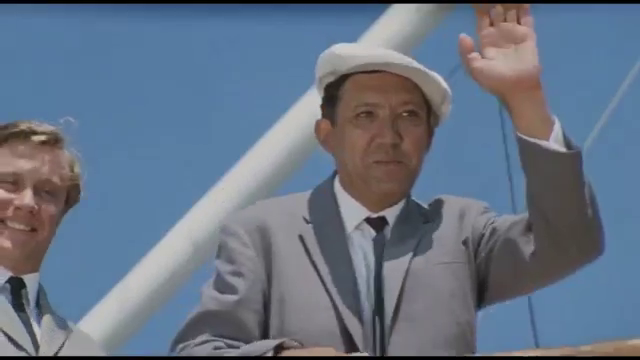

In [181]:
# Загружаем мтцнн
mtcnn = MTCNN()

ourResNet = ResNet(1, 10).to(device)
ourResNet.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/PyTorch/5/cv/emotion_detection_model_state_50_epochs.pth'))
ourResNet.eval()
# Создаем объект нашего класса приложения
fcd = FaceDetector(mtcnn, model)
# Запускаем
fcd.run()

##Probably cv2_imshow is different from cv2.imshow and we see frames of the movie in each row. On the first picture we can see result of work our net.